# 2. 실습: Multilayer Perceptron (MLP)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print('PyTorch version:[%s].' % (torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:[%s].' % (device))

PyTorch version:[1.9.0+cu102].
device:[cuda:0].


<br>

## 2.1 Dataset

- MNIST 데이터셋 사용

In [ ]:
from torchvision import datasets, transforms

mnist_train = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)
print('mnist_train:\n', mnist_train,'\n')
print('mnist_test:\n', mnist_test,'\n')
print('Done.')

mnist_train:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor() 

mnist_test:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: ToTensor() 

Done.


<br>

## 2.2 Data Iterator

- PyTorch 는 SGD 를 하기 위해 `DataLoader()` 를 제공한다.
- `shuffle=True` 옵션을 지정하는 것을 잘 기억하자.

In [ ]:
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
print('Done.')

Done.


<br>

## 2.3 Define the MLP model

- `nn.init.kaiming_normal_()`
  - He normal initialization
  - Xavier 방법을 약간 변형한 모양
  - $W \sim N(0, \operatorname{Var}(W))$
  - $\operatorname{Var}(W)=\sqrt{\frac{2}{n_{\text {in }}}}$


In [ ]:
class MultiLayerPerceptronClass(nn.Module): # nn.Module 에서 기본적인 함수들(ex. forward() 등)을 가져오기 위해 상속 받음
    """
        Multilayer Perceptron (MLP) Class
    """
    def __init__(self, name='mlp', xdim=784, hdim=256, ydim=10):
        super(MultiLayerPerceptronClass, self).__init__() # 원래의 nn.Module 초기화
        self.name = name
        self.xdim = xdim
        self.hdim = hdim
        self.ydim = ydim
        # nn.Linear() : Applies a linear transformation to the incoming data. y = xA^T + b
        self.lin_1 = nn.Linear(self.xdim, self.hdim)
        self.lin_2 = nn.Linear(self.hdim, self.ydim)
        self.init_param() # initialize parameters (새로운 initialize 가 필요할 때 활용)

    def init_param(self):
        nn.init.kaiming_normal_(self.lin_1.weight) # kaiming_normal_() : He normal initialization
        nn.init.zeros_(self.lin_1.bias)
        nn.init.kaiming_normal_(self.lin_2.weight)
        nn.init.zeros_(self.lin_2.bias)

    def forward(self, x): # 클래스 형태로 만든 이유가 forward() 함수를 사용하기 위함이다.
        net = x
        net = self.lin_1(net)
        net = F.relu(net)
        net = self.lin_2(net)
        return net

M = MultiLayerPerceptronClass(name='mlp', xdim=784, hdim=256, ydim=10).to(device)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(M.parameters(), lr=1e-3) # 어떤 paramters 를 optimize 할 지 지정
print('Done.')

Done.


<br>

## 2.4 Simple Forward Path of the MLP Model

- PyTorch 의 가장 큰 장점이 Session 이 없다는 점이다.
  - 바로 네트워크를 만들고 네트워크를 run 해볼 수 있다.
- torch 에서는 내가 사용하고 있는 변수를 device 에 넣어줘야 한다.

In [ ]:
x_numpy = np.random.rand(2, 784) # 2개의 샘플 데이터 생성
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = M.forward(x_torch) # forward path
y_numpy = y_torch.detach().cpu().numpy() # torch tensor to numpy array (torch tensor 를 numpy array 로 변환)
print(f"x_numpy:\n{x_numpy}\n")
print(f"x_torch:\n{x_torch}\n")
print(f"y_torch:\n{y_torch}\n")
print(f"y_numpy:\n{y_numpy}\n")

x_numpy:
[[0.47581754 0.59368026 0.87800113 ... 0.78605878 0.98431884 0.36315314]
 [0.85442022 0.46614166 0.26990077 ... 0.59894065 0.8157765  0.4544029 ]]

x_torch:
tensor([[0.4758, 0.5937, 0.8780,  ..., 0.7861, 0.9843, 0.3632],
        [0.8544, 0.4661, 0.2699,  ..., 0.5989, 0.8158, 0.4544]],
       device='cuda:0')

y_torch:
tensor([[-0.2298,  0.5998, -0.1908,  0.3428,  0.3288, -1.2714, -1.0600,  1.6186,
          0.2145, -0.8172],
        [-0.0723,  0.4505, -0.1179,  0.6869, -0.1770, -0.8970, -1.0099,  1.5908,
         -0.5825, -1.3204]], device='cuda:0', grad_fn=<AddmmBackward>)

y_numpy:
[[-0.22976398  0.59977525 -0.19078998  0.34283313  0.32876346 -1.2713803
  -1.0600326   1.6185951   0.21449324 -0.8171635 ]
 [-0.07226863  0.45046705 -0.11790295  0.68693566 -0.17696023 -0.8970152
  -1.0099206   1.5907514  -0.58245176 -1.3204418 ]]



<br>

- `x_torch` 를 `forward()` 가 아닌 클래스의 파라미터로 넣어줘도 `y_torch` 를 얻을 수 있다.
  - 알아서 `forward()` 를 불러옴
- 하지만 `forward()` 명시적으로 표시해주는 것이 가독성이 좋을 수 있다.

In [ ]:
x_numpy = np.random.rand(2, 784) # 2개의 샘플 데이터 생성
x_torch = torch.from_numpy(x_numpy).float().to(device)
#y_torch = M.forward(x_torch) # forward path
y_torch = M(x_torch)
y_numpy = y_torch.detach().cpu().numpy() # torch tensor to numpy array (torch tensor 를 numpy array 로 변환)
print(f"x_numpy:\n{x_numpy}\n")
print(f"x_torch:\n{x_torch}\n")
print(f"y_torch:\n{y_torch}\n")
print(f"y_numpy:\n{y_numpy}\n")

x_numpy:
[[0.67825915 0.16672871 0.31133482 ... 0.7178171  0.82259416 0.82451239]
 [0.52239268 0.670657   0.76111473 ... 0.6530679  0.24175699 0.45276978]]

x_torch:
tensor([[0.6783, 0.1667, 0.3113,  ..., 0.7178, 0.8226, 0.8245],
        [0.5224, 0.6707, 0.7611,  ..., 0.6531, 0.2418, 0.4528]],
       device='cuda:0')

y_torch:
tensor([[ 5.2501e-01,  3.2402e-01,  2.7666e-01,  6.7011e-01,  5.2388e-01,
         -1.7652e-01, -1.1999e+00,  1.0737e+00, -3.9296e-01, -1.4828e+00],
        [-1.5658e-03,  7.3512e-01,  5.5516e-01,  4.2362e-01, -1.2353e-01,
         -1.2619e+00, -6.6645e-01,  1.3915e+00, -1.6545e+00, -4.6088e-01]],
       device='cuda:0', grad_fn=<AddmmBackward>)

y_numpy:
[[ 5.2500987e-01  3.2401928e-01  2.7666384e-01  6.7010701e-01
   5.2387983e-01 -1.7652272e-01 -1.1998830e+00  1.0736611e+00
  -3.9295658e-01 -1.4828105e+00]
 [-1.5657991e-03  7.3511803e-01  5.5516380e-01  4.2362431e-01
  -1.2352878e-01 -1.2619394e+00 -6.6644800e-01  1.3915215e+00
  -1.6544971e+00 -4.6088016e-01]

<br>

## 2.5 Check Parameters

- 784 -> 256 -> 10

In [ ]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx, (param_name, param) in enumerate(M.named_parameters()):
    param_numpy = param.detach().cpu().numpy()
    n_param += len(param_numpy.reshape(-1))
    print("[%d] name:[%s] shape:[%s]." % (p_idx, param_name, param_numpy.shape))
    print ("    val:%s\n"%(param_numpy.reshape(-1)[:5]))
print ("Total number of parameters:[%s]."%(format(n_param,',d')))

[0] name:[lin_1.weight] shape:[(256, 784)].
    val:[ 0.035 -0.059  0.019  0.025 -0.039]

[1] name:[lin_1.bias] shape:[(256,)].
    val:[0. 0. 0. 0. 0.]

[2] name:[lin_2.weight] shape:[(10, 256)].
    val:[-0.062 -0.051  0.003  0.069  0.078]

[3] name:[lin_2.bias] shape:[(10,)].
    val:[0. 0. 0. 0. 0.]

Total number of parameters:[203,530].


<br>

## 2.6 Evaluation Function

- `model.eval()`
  - Dropout 이나 Batch Normalization 과 같이 train 과 execution case 가 달라지는 경우가 있다.
  - 이를 위해 mode change 를 실시한다. (eval 모드로 변경)
- `torch.max()` : 최대값과 최대값 인덱스를 함께 리턴

In [ ]:
def func_eval(model, data_iter, device):
    with torch.no_grad(): # no_grad() : gradient 를 계산하지 않겠다.
        model.eval() # activate evaluate mode (affects Dropout and BN)
        n_total, n_correct = 0, 0
        for batch_in, batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model(batch_in.view(-1, 28*28).to(device))
            _, y_pred = torch.max(model_pred.data, 1) # max() 를 하면 label 이 나온다.
            n_correct += (y_pred == y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        model.train() # back to train mode
    return val_accr
print('Done.')

Done.


<br>

## 2.7 Initial Evaluation

In [ ]:
train_accr = func_eval(M, train_iter, device)
test_accr = func_eval(M, test_iter, device)
print('train_accr:[%.3f] test_accr:[%.3f]' % (train_accr, test_accr))

train_accr:[0.112] test_accr:[0.111]


<br>

- initialization 한 번 더 하면 다른 값이 나올 수 있다.

In [ ]:
M.init_param()
train_accr = func_eval(M, train_iter, device)
test_accr = func_eval(M, test_iter, device)
print('train_accr:[%.3f] test_accr:[%.3f]' % (train_accr, test_accr))

train_accr:[0.108] test_accr:[0.107]


<br>

## 2.8 Train

In [ ]:
print('Start training.')
M.init_param() # initialize parameters
M.train() # activate train mode
EPOCHS, print_every = 10, 1
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_in, batch_out in train_iter:
        # Forward path
        y_pred =  M.forward(batch_in.view(-1, 28*28).to(device))
        loss_out = loss(y_pred, batch_out.to(device))
        # Update
        optm.zero_grad() # reset gradient (to zero)
        loss_out.backward() # backpropagate 
        optm.step() # optimizer update
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(train_iter)
    # Print
    if ((epoch % print_every) == 0) or (epoch == (EPOCHS - 1)):
        train_accr = func_eval(M, train_iter, device)
        test_accr = func_eval(M, test_iter, device)
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
               (epoch,loss_val_avg,train_accr,test_accr))
print('Done.')

Start training.
epoch:[0] loss:[0.374] train_accr:[0.946] test_accr:[0.946].
epoch:[1] loss:[0.164] train_accr:[0.964] test_accr:[0.960].
epoch:[2] loss:[0.116] train_accr:[0.974] test_accr:[0.968].
epoch:[3] loss:[0.089] train_accr:[0.981] test_accr:[0.970].
epoch:[4] loss:[0.071] train_accr:[0.984] test_accr:[0.975].
epoch:[5] loss:[0.057] train_accr:[0.987] test_accr:[0.976].
epoch:[6] loss:[0.047] train_accr:[0.991] test_accr:[0.976].
epoch:[7] loss:[0.040] train_accr:[0.992] test_accr:[0.979].
epoch:[8] loss:[0.033] train_accr:[0.995] test_accr:[0.979].
epoch:[9] loss:[0.028] train_accr:[0.996] test_accr:[0.979].
Done.


<br>

## 2.9 Test

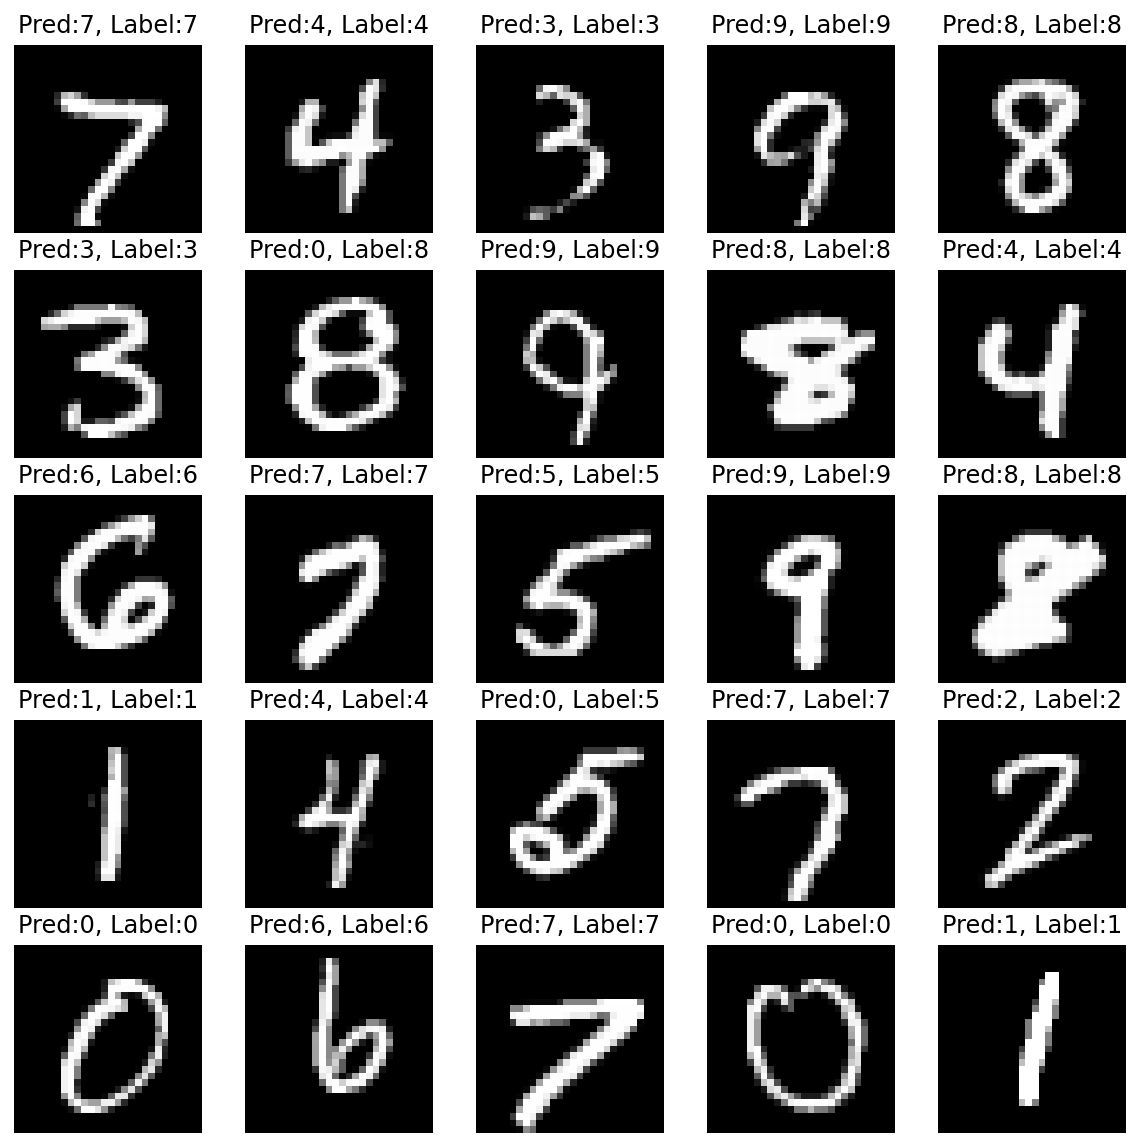

Done


In [ ]:
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets), n_sample, replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]
with torch.no_grad():
    y_pred = M.forward(test_x.view(-1, 28*28).type(torch.float).to(device))
y_pred = y_pred.argmax(axis=1)

plt.figure(figsize=(10,10))
for idx in range(n_sample):
    plt.subplot(5, 5, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(y_pred[idx],test_y[idx]))
plt.show()    
print ("Done")